<div style='text-align:center'>
    <h1> ========== COS710 - Assignment 3 ==========</h1>
    <h3>Reuben Jooste - u21457060</h3>
    <hr style='margin:0px 280px;'>
    <h1>=========== Packages ===========</h1>
</div>

In [2]:
# packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import math
from IPython.display import clear_output
import time
import multiprocessing
import sys
from queue import Queue
from tqdm.auto import tqdm
from functools import partial
from multiprocessing import Manager
import os
from IPython.display import FileLink
from IPython.display import HTML

<div style='text-align:center'><h1>========= Importing Data Files ==========</h1></div>

In [3]:
#load data - source data
source_data_unclean = pd.read_csv('/kaggle/input/diabetes-data-set/diabetes.csv')

#load data - target one data
target_one_data_unclean = pd.read_csv('/kaggle/input/input-data/diabetes_prediction_dataset.csv')

#load data - target two data
target_two_data_unclean = pd.read_csv('/kaggle/input/input-data/Dataset_of_Diabetes.csv')

# remove first two columns of target two since it is only the patient ID and No_Pation
target_two_data_unclean.drop(['ID', 'No_Pation'], axis=1, inplace=True)

<div style='text-align:center'><h1>========= Analysis on unclean data ==========</h1></div>

In [4]:
def plot_distributions(data, c):
    num_cols = data.select_dtypes(include=[np.number]).columns
    cat_cols = data.select_dtypes(include=[object]).columns

    num_cols_count = len(num_cols)
    cat_cols_count = len(cat_cols)

    total_cols = num_cols_count + cat_cols_count
    num_rows = (total_cols + 1) // 3

    fig, axs = plt.subplots(num_rows, 3, figsize=(12, 3 * num_rows))

    for i, col in enumerate(num_cols):
        if len(data[col]) != 0:
            axs[i // 3, i % 3].hist(data[col], edgecolor='black', alpha=0.7, color=c)
            axs[i // 3, i % 3].set_title(f'Histogram of {col}')
            axs[i // 3, i % 3].set_xlabel(col)
            axs[i // 3, i % 3].set_ylabel('Frequency')

    for i, col in enumerate(cat_cols, start=num_cols_count):
        if len(data[col]) != 0:
            value_counts = data[col].value_counts()
            axs[i // 3, i % 3].bar(value_counts.index, value_counts.values, color=c)
            axs[i // 3, i % 3].set_title(f'Bar chart of {col}')
            axs[i // 3, i % 3].set_xlabel(col)
            axs[i // 3, i % 3].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()
    
def plot_box_plots(data):
    plt.figure(figsize=(15, 8))

    # Exclude the last column
    data_to_plot = data.iloc[:, :-1]  # Exclude the last column

    data_to_plot.boxplot()
    plt.xticks(rotation=45)
    plt.show()

# handle missing values
# we will replace any missing values with the median or mean
# we will also replace any outliers with the median

def clean_data(data, dataset_name):        
    # Replace any outliers
    # Iterate over each column in the DataFrame
    columns = data.columns
    for feature in columns:
        if feature not in ['Outcome', 'diabetes', 'CLASS', 'Gender', 'smoking_history', 'gender', 'hypertension', 'heart_disease']:  # Skip 'Outcome' column if it's not a feature
            # Calculate Q1, Q3, and IQR
            Q1 = data[feature].quantile(0.25)
            Q3 = data[feature].quantile(0.75)
            IQR = Q3 - Q1

            # Define lower and upper bounds
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            # Identify outliers
            outliers = data[(data[feature] < lower_bound) | (data[feature] > upper_bound)]

            # Replace outliers with the median
            median = data[feature].median()
            data.loc[(data[feature] < lower_bound) | (data[feature] > upper_bound), feature] = median
        elif feature == 'Gender':
            # replace any 'f' with 'F'
            data.loc[data["Gender"] == "f", "Gender"] = 'F'
            
            # now replace the values with 0s and 1s
            data.loc[data["Gender"] == "M", "Gender"] = 1
            data.loc[data["Gender"] == "F", "Gender"] = 0
            
            # change the type of the column
            data['Gender'] = data['Gender'].astype(int)
            
        elif feature == 'gender':
            # drop all rows if gender is 'other'
            indexGender = data[(data['gender'] == 'Other')].index
            data.drop(indexGender, inplace=True)
            
            # now replace the values with 0s and 1s
            data.loc[data["gender"] == "Male", "gender"] = 1
            data.loc[data["gender"] == "Female", "gender"] = 0
            
            # change the type of the column
            data['gender'] = data['gender'].astype(int)
            
        elif feature == 'CLASS':
            # replace any 'Y ' with 'Y' and any 'N ' with 'N'
            data.loc[data["CLASS"] == "Y ", "CLASS"] = 'Y'
            data.loc[data["CLASS"] == "N ", "CLASS"] = 'N'
            
            # remove all rows with 'P' as the CLASS label since the dataset does not include a "BloodSugar" column
            # being classified as 'P' means pre-diabetic with higher blood sugar levels than normal
            # since the dataset does not have a column for this attribute, it would create a bias for our model's prediction when it comes to
            # classifying if the patient is a diabetic or not
            indexClass = data[(data['CLASS'] == 'P')].index
            data.drop(indexClass, inplace=True)            
            
            # replace the Yes values with 1 and the No values with 0
            data.loc[data["CLASS"] == "Y", "CLASS"] = 1
            data.loc[data["CLASS"] == "N", "CLASS"] = 0
            
            # change the type of the column
            data['CLASS'] = data['CLASS'].astype(int)
            
    # Update the names of the features that are in common:
    if dataset_name == 'source':
        data.rename(columns = {'Age':'AGE'}, inplace = True)
        data.rename(columns = {'Glucose':'GLUCOSE'}, inplace = True)
        
        # reorder cols to ensure source and target domain have the same index for the same feature
        data.insert(0, 'AGE', data.pop('AGE'))
        data.insert(1, 'BMI', data.pop('BMI'))
        data.insert(2, 'GLUCOSE', data.pop('GLUCOSE'))

    elif dataset_name == 'target-one':
        data.rename(columns = {'age':'AGE'}, inplace = True)
        data.rename(columns = {'bmi':'BMI'}, inplace = True)
        data.rename(columns = {'blood_glucose_level':'GLUCOSE'}, inplace = True)
        
        # reorder cols to ensure source and target domain have the same index for the same feature
        data.insert(0, 'AGE', data.pop('AGE'))
        data.insert(1, 'BMI', data.pop('BMI'))
        data.insert(2, 'GLUCOSE', data.pop('GLUCOSE'))
        
    elif dataset_name == 'target-two':
        # reorder cols to ensure source and target domain have the same index for the same feature
        data.insert(0, 'AGE', data.pop('AGE'))
        data.insert(1, 'BMI', data.pop('BMI'))        
        
    return data 

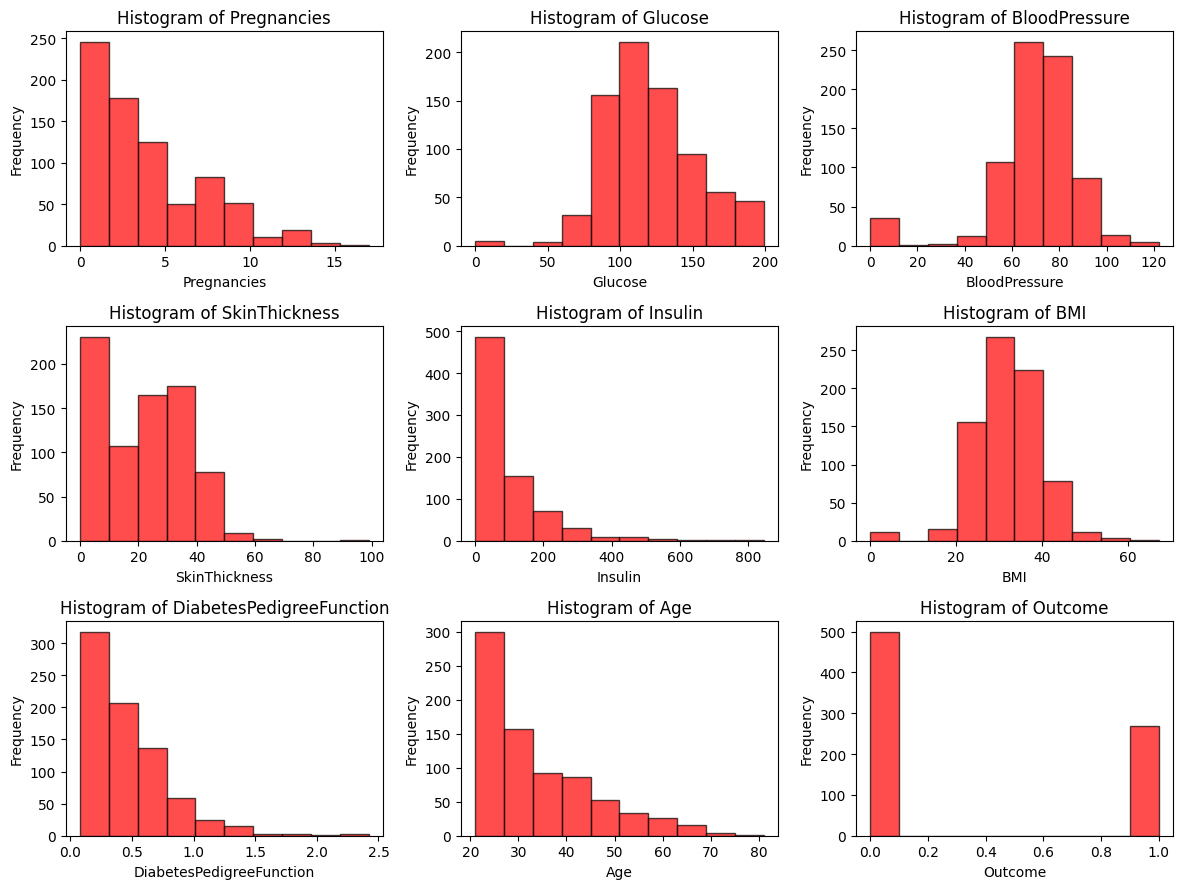

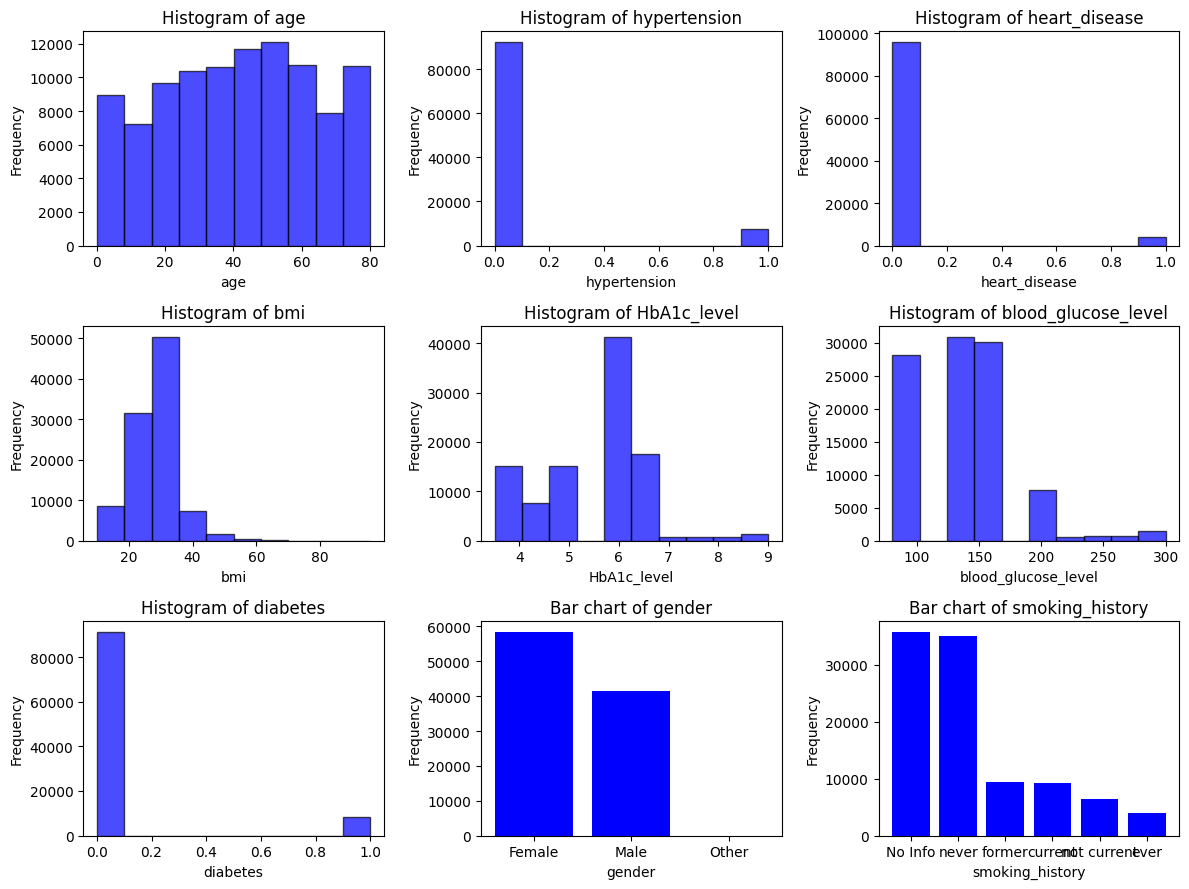

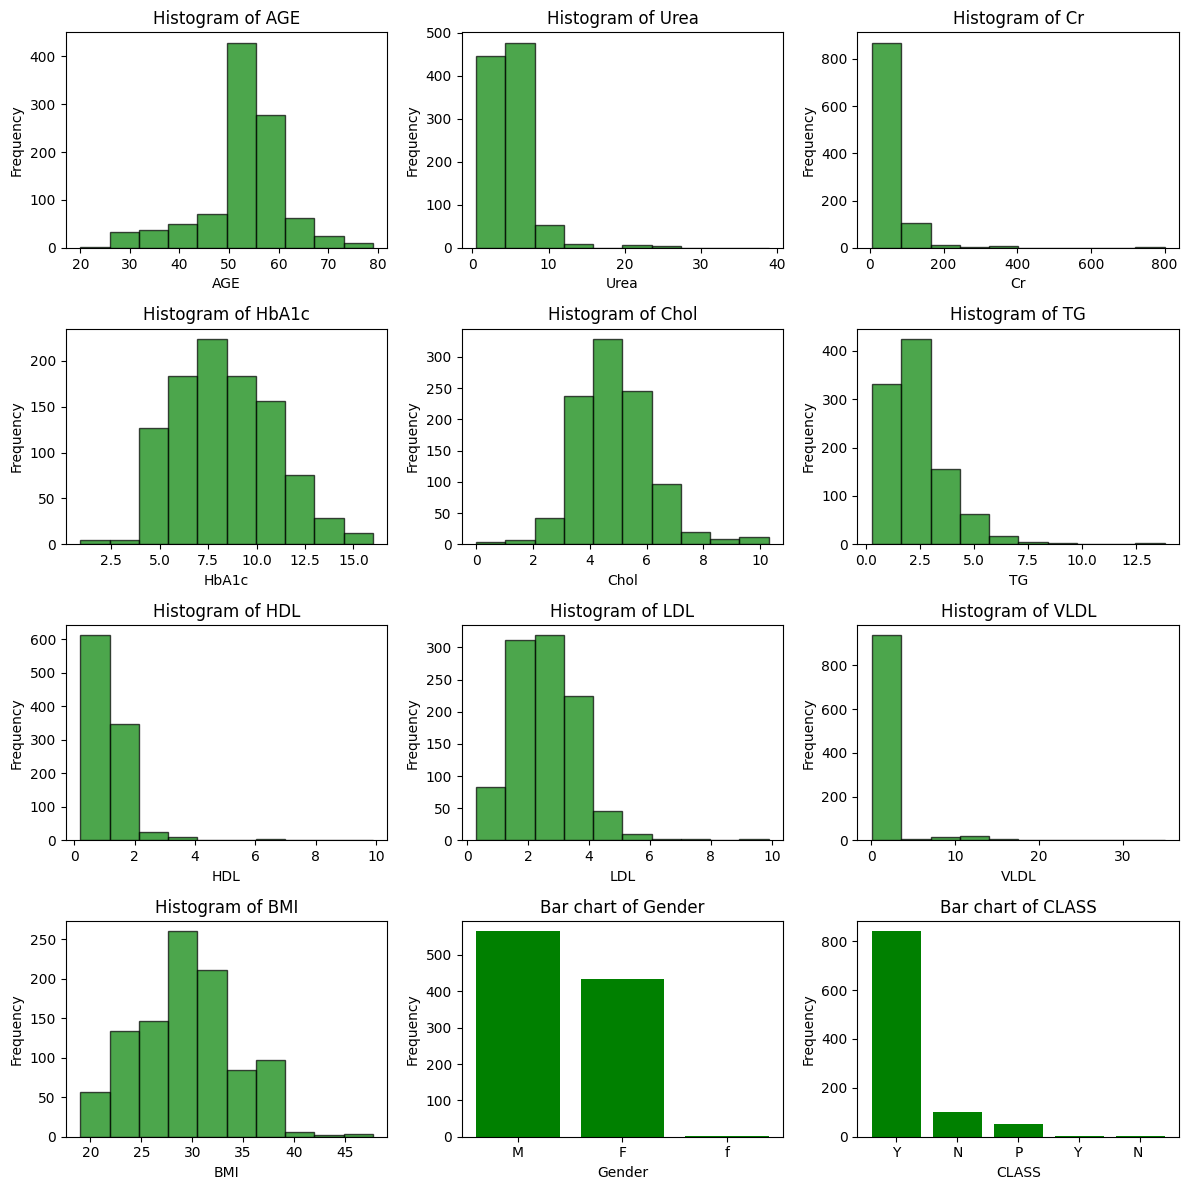

In [5]:
# Analyse unclean data distribution

# plot histograms
plot_distributions(source_data_unclean, 'red') # source

plot_distributions(target_one_data_unclean, 'blue') # target one

plot_distributions(target_two_data_unclean, 'green') # target two

### Source Dataset - We can see the Glucose, Bloodpressure, and BMI feaures have a more normal distribution than the other features. Usually we would replace any missing values with the MEAN but we know the MEAN is sensitive to outliers so we will first need to analyse if there are any outliers.

### Target One Dataset - Similar to the source data we will first need to evaluate if there are any outliers. We also notice that the Gender has very few, almost zero occurences for the "Other" category meaning it will have no affect on the prediction of the model. We will thus remove all occurences of these values.

### Target Two Dataset - We can clearly see that some of the features have outliers so we will first have to process these values similar to how we will handle it in the previous two dataset. We also see that the Gender and CLASS attributes have errors where a False (F) value is indicated with a lowercase 'f' and also for the CLASS attribute it seems there are two different values for "Yes" and "No".

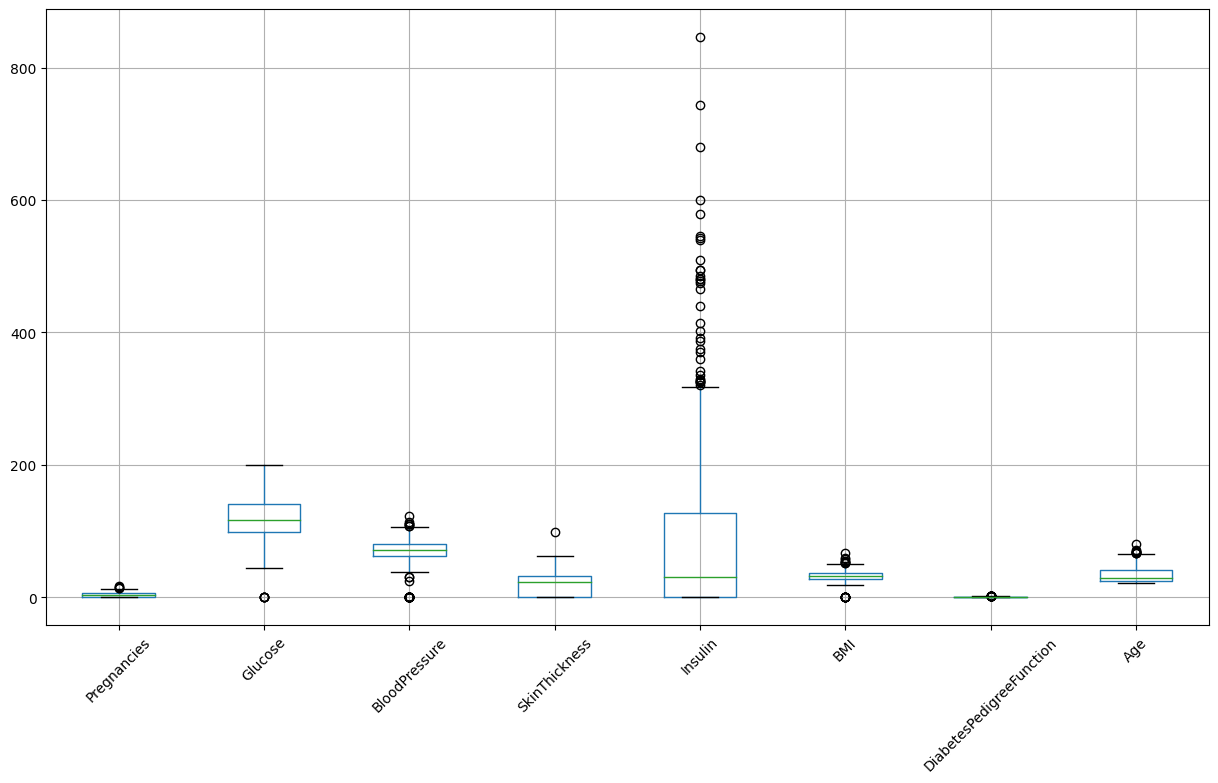

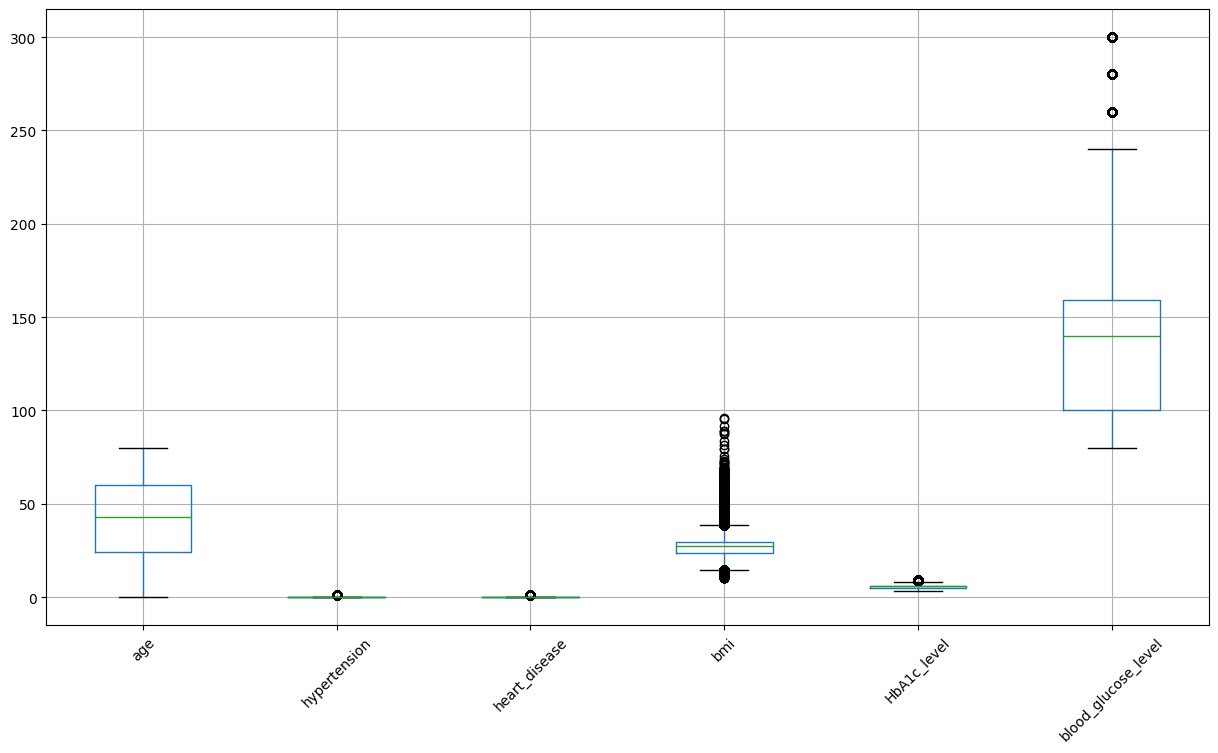

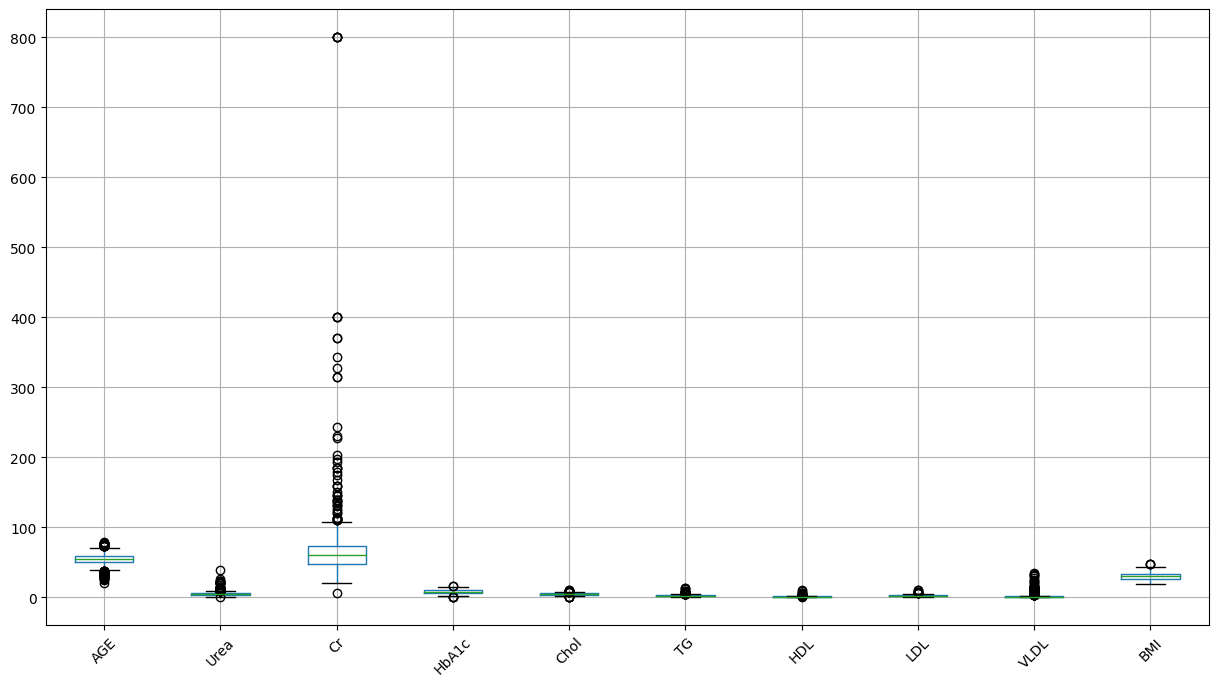

In [6]:
# Create box plots to identify outliers (if any)
plot_box_plots(source_data_unclean)

# Create box plots to identify outliers (if any)
plot_box_plots(target_one_data_unclean)

# Create box plots to identify outliers (if any)
plot_box_plots(target_two_data_unclean)

### We can clearly see that some of the features have outliers. We need to replace these values using the median because the median is less sensitive to outliers compared to the mean. This means that the median still has sort of a central tendency of the data.

## We now look at the cleaned data...

In [7]:
source_data_clean = clean_data(source_data_unclean, 'source')

target_one_data_clean = clean_data(target_one_data_unclean, 'target-one')

target_two_data_clean = clean_data(target_two_data_unclean, 'target-two')

/tmp/ipykernel_33/1322237536.py:65: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '30.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[(data[feature] < lower_bound) | (data[feature] > upper_bound), feature] = median


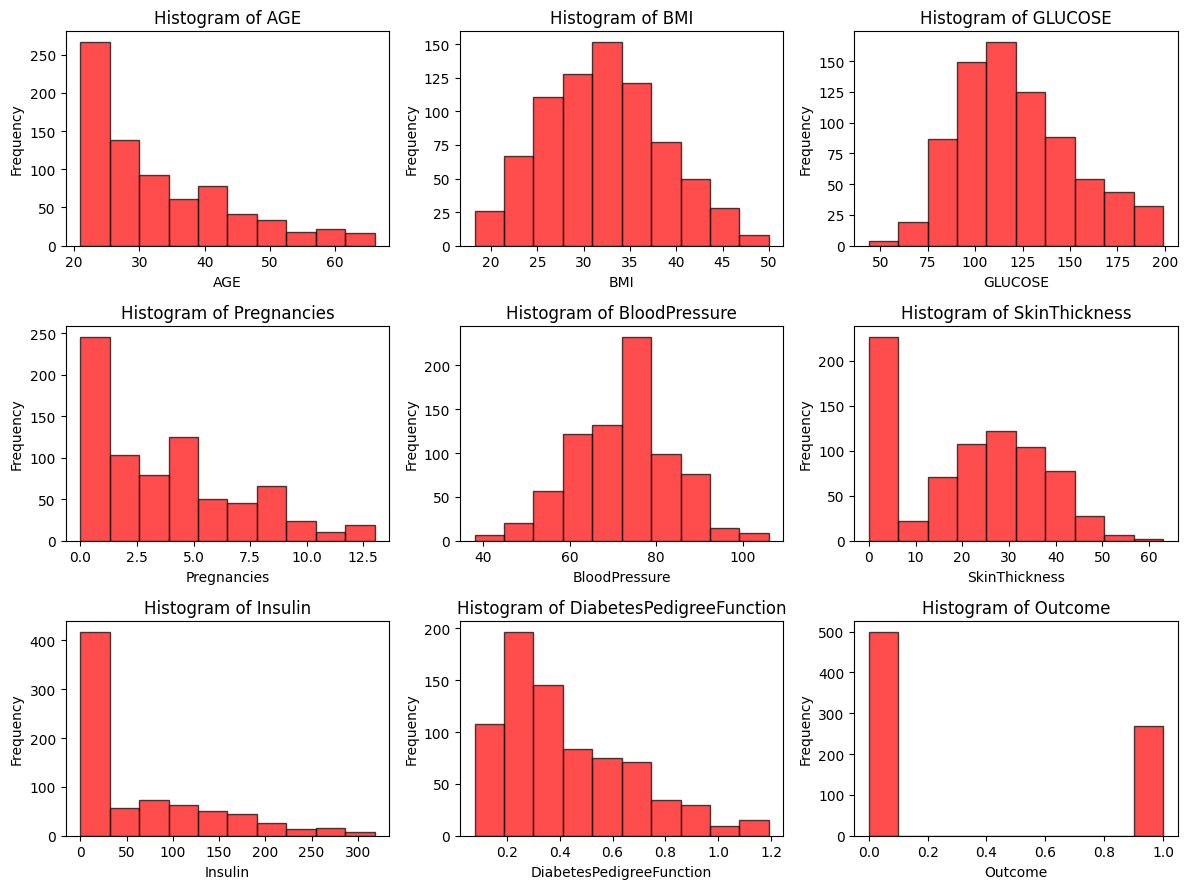

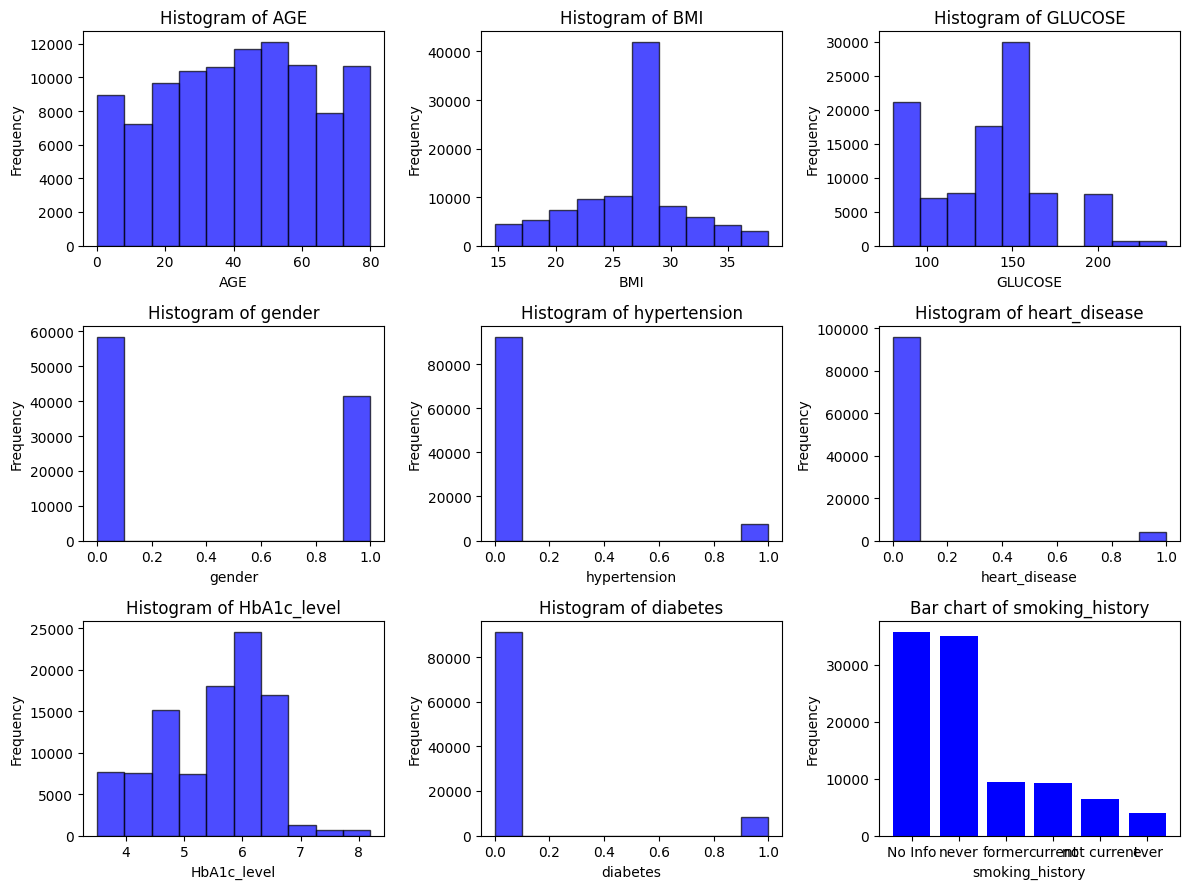

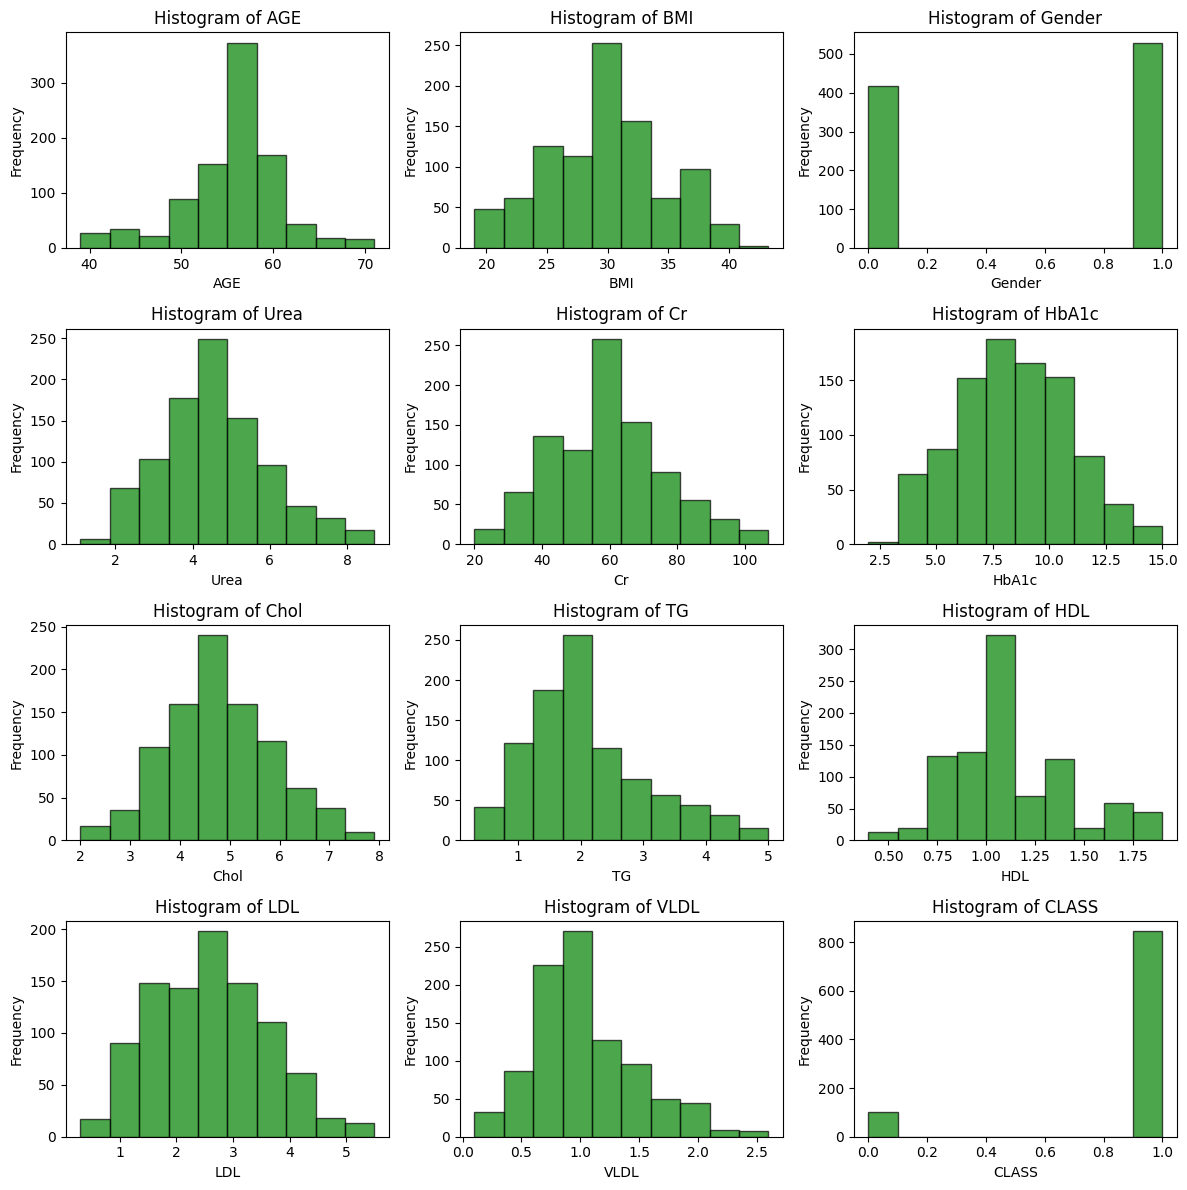

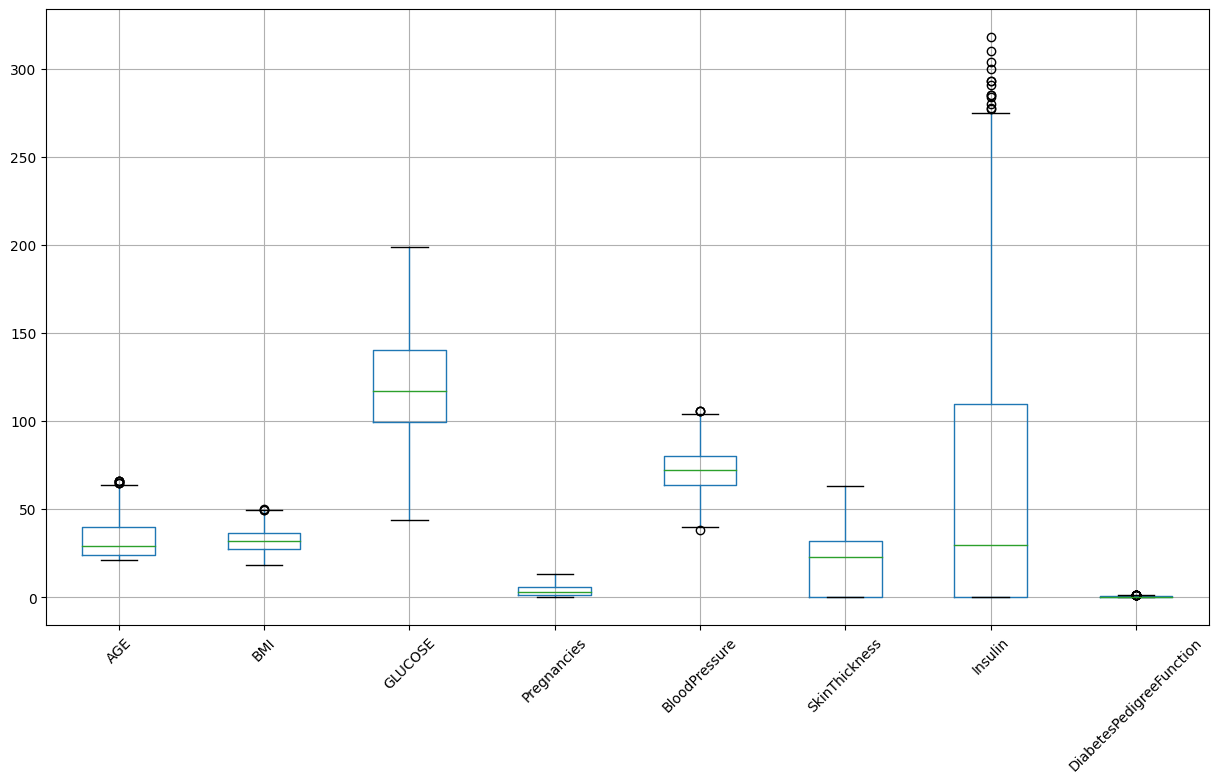

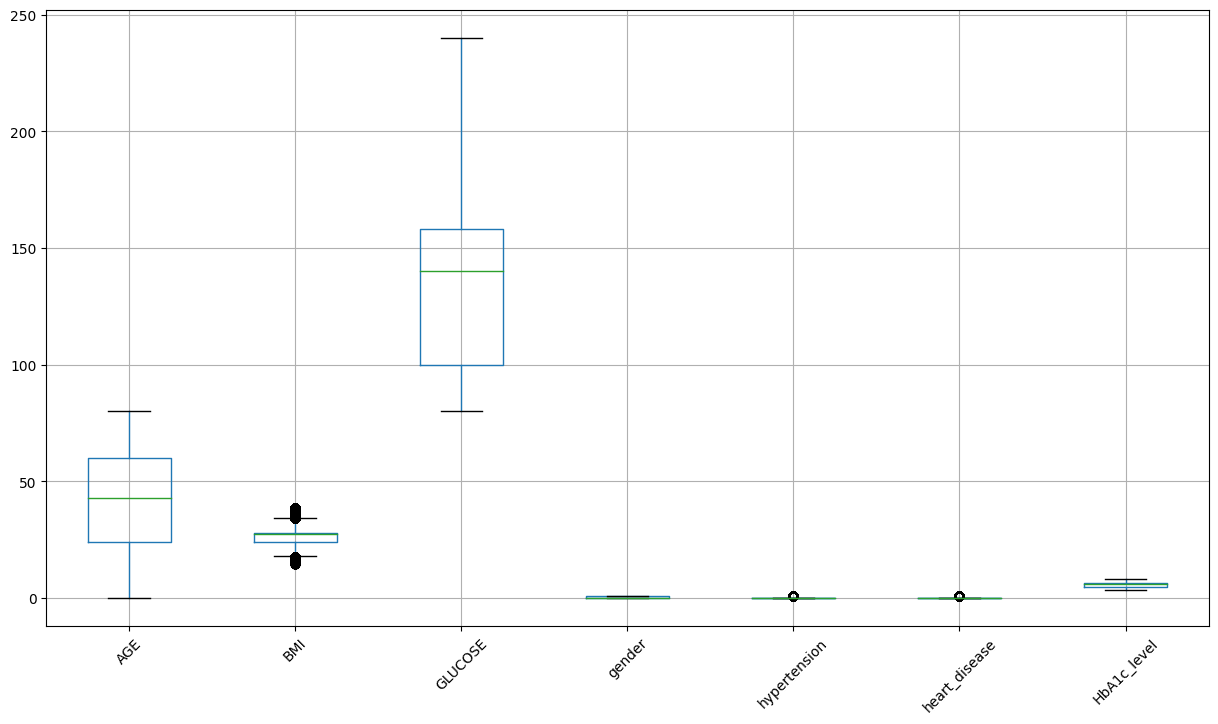

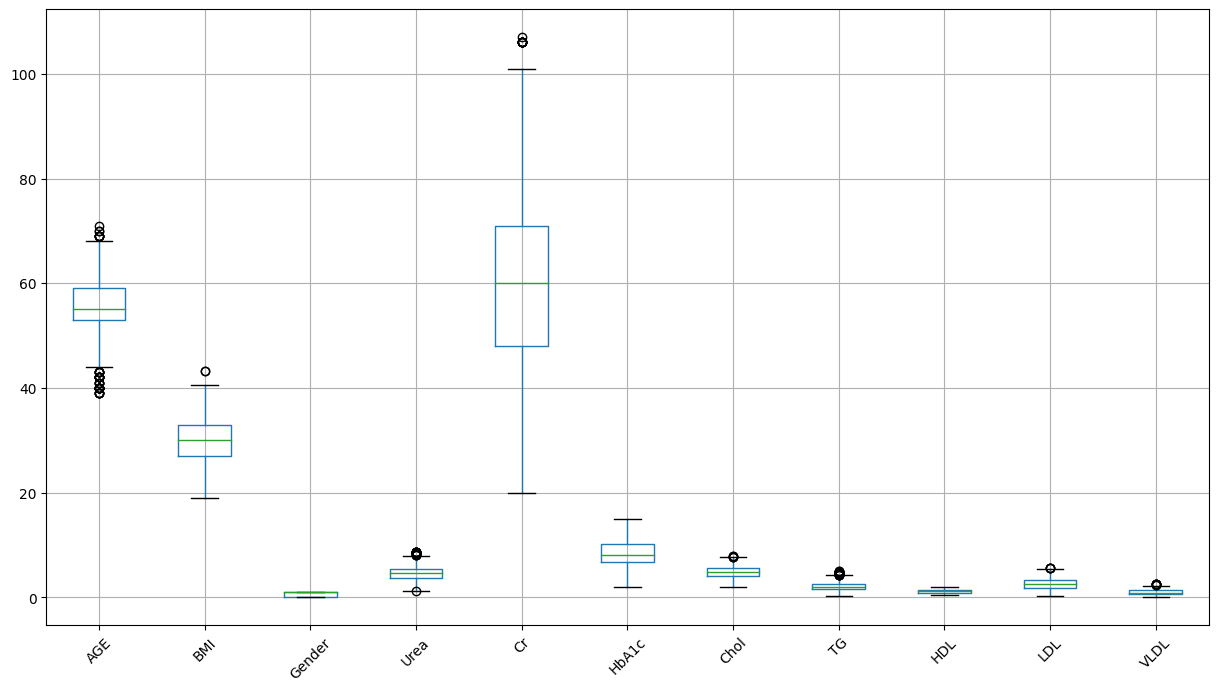

In [8]:
# plot histograms
plot_distributions(source_data_clean, 'red') # source

plot_distributions(target_one_data_clean, 'blue') # target one

plot_distributions(target_two_data_clean, 'green') # target two

plot_box_plots(source_data_clean)

plot_box_plots(target_one_data_clean)

plot_box_plots(target_two_data_clean)

### Now we see that all the data is cleaned and all outliers have been replaced.

# ============= Code needed for main program =============

In [9]:
# Colours Class
class bcolors:
    ANSI_RESET = "\u001B[0m"
    ANSI_RED = "\u001B[31m"
    ANSI_GREEN = "\u001B[32m"
    ANSI_YELLOW = "\u001B[33m"
    ANSI_BLUE = "\u001B[34m"
    ANSI_PURPLE = "\u001B[35m"
    ANSI_CYAN = "\u001B[36m"
    ANSI_WHITE = "\u001B[37m"
    ANSI_BLACK = "\u001B[30m"
    ANSI_BOLD = '\033[1m'
    
# Node Class
class Node:
    def __init__(self, feature, threshold, children, at_depth, data=None, data_labels=None, parent=None, label=None):
        self.feature = feature  # Feature used for splitting (if not a leaf)
        self.threshold = threshold  # Threshold value for split (if not a leaf)
        if children is not None:
            self.children = children.copy() # copy array of children
        else:
            self.children = []
        self.at_depth = at_depth
        self.label = label  # Predicted class label (for leaf nodes)
        self.parent = None # Keep reference of the parent for crossover purposes
        self.data = data
        self.data_labels = data_labels
        
    def is_leaf(self):
        return self.label != None or len(self.children) == 0

In [10]:
    
def train_test_split(data, seed, split_ratio=0.8):
    # Shuffle the data randomly
    data = data.sample(frac=1, random_state=seed)
    
    # Calculate the split index based on the split ratio
    split_index = int(len(data) * split_ratio)
    
    # Split the data into training and testing sets
    training_data = data[:split_index]
    testing_data = data[split_index:]
    
    return training_data, testing_data

In [68]:
# ============ MAIN PROGRAM ==============
def setupRules(input_data):
    startingSymbol = "<F><op><Child><Child>" # we use two children as we need two output nodes
    featureSymbol = list(input_data.columns)
    operatorSymbol = [">", "<", ">=", "<="]
    childSymbol = ["0", "1", startingSymbol]
    
    return startingSymbol, featureSymbol, operatorSymbol, childSymbol

def binaryToDecimal(binary):
    idx = len(binary)-1
    
    decimal, i = 0, 0
    while (idx > 0):
        decimal += int(binary[idx]) * pow(2, i)
        i += 1
        idx -= 1
    return decimal

def mapChromosomeToTree(full_data, X_train, chromosome, startingSymbol, featureSymbol, operatorSymbol, childSymbol, maxDepth, curCodon=0, curDepth=0):
    # calculate sum of decimal values for bits to use as seed
    seed = 0
    for codon in chromosome:
        seed += binaryToDecimal(codon)
    random.seed(seed)
    
    grammarStr = startingSymbol
    grammarArr = []
    children_done = 0
    
    # Continue until all symbols are mapped
    while grammarStr.find('<F>') != -1 or grammarStr.find('<op>') != -1 or grammarStr.find('<Child>') != -1:
        # check if we need to wrap to first codon
        if curCodon >= len(chromosome):
            curCodon = 0
        
        if grammarStr.find('<F>') != -1 or grammarStr.find('<op>') != -1: # these will always happen together
            
            # choose feature based on remainder value
            remainder = binaryToDecimal(chromosome[curCodon]) % len(featureSymbol) # MOD by number of production rules
            feature_selected = featureSymbol[remainder]
            
            curCodon += 1
            
            # check if we can create a new node with threshold value
            features = list(full_data.columns[:])
            feature_values = X_train.values[:, features.index(feature_selected)]
            
            if len(feature_values) == 0:
                # return leaf node
                if remainder < 2:
                    label_selected = childSymbol[remainder]
                else:
                    label_selected = childSymbol[random.choice([0,1])] # randomly select a leaf node
                
                grammarStr = grammarStr.replace(startingSymbol, "(" + label_selected + ")", 1) # replace first occurence
                
                if grammarArr == []:
                    grammarArr.append(int(label_selected))
                else:
                    grammarArr.append([int(label_selected)])
                
            else:
                # check if we need to wrap to first codon
                if curCodon >= len(chromosome):
                    curCodon = 0

                # choose operator based on remainder value
                remainder = binaryToDecimal(chromosome[curCodon]) % len(operatorSymbol) # MOD by number of production rules
                operator_selected = operatorSymbol[remainder]
                
                if feature_selected == "smoking_history":
                    featureSymbol.remove('smoking_history')

                    num_categories = len(full_data['smoking_history'].unique())

                    for _ in range(num_categories - 2): # we already have two children tags
                        grammarStr += "<Child>"

                    # no threshold
                    grammarStr = grammarStr.replace('<F>', "(" + feature_selected + ',', 1) # replace first occurence
                    grammarArr.append(feature_selected)

                    grammarStr = grammarStr.replace('<op>', operator_selected + ',' + 'None,', 1) # replace first occurence
                    grammarArr.append(operator_selected)
                    grammarArr.append(None) #no threshold

                    # Split data into different categories
                    splitted_data = split_data_categories(X_train, features, feature_selected, full_data)

                else:
                    threshold = round(random.uniform(np.min(feature_values), np.max(feature_values)),4)

                    grammarStr = grammarStr.replace('<F>', "(" + feature_selected + ',', 1) # replace first occurence
                    grammarArr.append(feature_selected)

                    # Split data based on the chosen feature and threshold
                    splitted_data = split_data(X_train, features, feature_selected, threshold, operator_selected)

                    grammarStr = grammarStr.replace('<op>', operator_selected + ',' + str(threshold) + ',', 1) # replace first occurence
                    grammarArr.append(operator_selected)
                    grammarArr.append(threshold)

                curCodon += 1
                # check if we need to wrap to first codon
                if curCodon >= len(chromosome):
                    curCodon = 0
            
        if grammarStr.find('<Child>') != -1:
            # choose feature based on remainder value
            remainder = binaryToDecimal(chromosome[curCodon]) % len(childSymbol) # MOD by number of production rules
            curCodon += 1
            
            if remainder >= 2 and curDepth <= maxDepth: # we create a new child node     
                subGrammarArr, subGrammarStr = mapChromosomeToTree(full_data, splitted_data[children_done], chromosome, startingSymbol, featureSymbol.copy(), operatorSymbol, childSymbol, maxDepth, curCodon, curDepth+1)
                
                # we add the sub parts
                grammarStr = grammarStr.replace('<Child>', subGrammarStr + ',', 1) # replace first occurence
                grammarArr.append(subGrammarArr)
                
            elif remainder >= 2 and curDepth >= maxDepth:
                label_selected = childSymbol[random.choice([0,1])] # randomly select a leaf node
                
                grammarStr = grammarStr.replace('<Child>', "(" + label_selected + ")", 1) # replace first occurence
                grammarArr.append([int(label_selected)])
                
            else:
                label_selected = childSymbol[remainder]
                
                grammarStr = grammarStr.replace('<Child>', "(" + label_selected + ")", 1) # replace first occurence
                grammarArr.append([int(label_selected)])
                
            children_done += 1
                
            # check if we need to wrap to first codon
            if curCodon >= len(chromosome):
                curCodon = 0
    
    if grammarStr[-1] == ',':
        grammarStr = grammarStr[:-1] + ')'
    else:
        grammarStr += ')'

    return grammarArr, grammarStr

def split_data(data, features, feature, threshold, operator):
    # Split data into data left and right of the threshold value
    if operator == '>':
        right_index = data[feature] > threshold
    elif operator == '<':
        right_index = data[feature] < threshold
    elif operator == '>=':
        right_index = data[feature] >= threshold
    elif operator == '<=':
        right_index = data[feature] <= threshold
        
    left_index = ~right_index

    left_data = data[left_index]
    right_data = data[right_index]

    return left_data, right_data

def split_data_categories(X_train, features, feature, full_data):
    data = []
    
    categories = full_data[feature].unique()
    
    for i in range(len(categories)):
        index = X_train[feature] == categories[i]
        data.append(X_train[index])
        
    return data
    

def split_data_by_chunks(data, chunk_size):
    # Split the data into chunks of desired size
    chunks = [data[i:i+chunk_size] for i in range(0, len(data), chunk_size)]
    return chunks

def evaluate_individual(tree_array, X_train, Y_train, features):
    # Split data into chunks
    data_size = len(X_train)
    chunk_size = int(data_size * 0.1)
    X_train_chunks = split_data_by_chunks(X_train, chunk_size)
    Y_train_chunks = split_data_by_chunks(Y_train, chunk_size)
    chunk_fitnesses = []
    
    for X_train_chunk, Y_train_chunk in zip(X_train_chunks, Y_train_chunks):
        chunk_fitnesses.append(evaluate_tree(tree_array, X_train_chunk, Y_train_chunk, features, X_train))

    # Accumulate the values
    correct_predictions, TP_total, FP_total, FN_total = 0, 0, 0, 0
    for i in range(len(chunk_fitnesses)):
        correct_predictions += chunk_fitnesses[i][0]
        TP_total += chunk_fitnesses[i][1]
        FP_total += chunk_fitnesses[i][2]
        FN_total += chunk_fitnesses[i][3]
        
    # Calculate accuracy as the fitness score
    accuracy = correct_predictions / data_size
    precision = TP_total / (TP_total + FP_total) if (TP_total + FP_total) > 0 else 0
    recall = TP_total / (TP_total + FN_total) if (TP_total + FN_total) > 0 else 0
    F1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return [F1_score, accuracy, precision, recall]
    
def evaluate_tree(tree_array, X_train, Y_train, features, full_dataframe):  
    correct_predictions = 0
    data_size = len(X_train)
    TP = 0  # True Positives
    FP = 0  # False Positives
    FN = 0  # False Negatives
    # Check if feature is a categorical feature
    categorical_columns = full_dataframe.select_dtypes(include=[object]).columns
    # run through the training data
    for i in range(data_size): # example tree input: ['Insulin', '>', 128.0094, ['BloodPressure', '<', 40.6347, ['SkinThickness', '>=', 17.7812, ['1'], ['0']]]]
        iterator_arr = tree_array.copy()
        
        instance = X_train.iloc[i, :]
        target_label = Y_train.iloc[i]
    
        while not iterator_arr[0] in [0, 1]:
            feature = iterator_arr[0]\
            
            if feature in categorical_columns:
                # get index of instance's category
                feature_values = list(full_dataframe[feature].unique())
                category_index = feature_values.index(instance[feature])

                # now follow the index branch
                iterator_arr = iterator_arr[category_index + 3] # first three indexes are feature, operator, threshold
            else:
                operator = iterator_arr[1]
                threshold = iterator_arr[2]

                if operator == '>':
                    iterator_arr = iterator_arr[4] if threshold > instance.get(feature) else iterator_arr[3]
                elif operator == '<':
                    iterator_arr = iterator_arr[4] if threshold < instance.get(feature) else iterator_arr[3]
                elif operator == '>=':
                    iterator_arr = iterator_arr[4] if threshold >= instance.get(feature) else iterator_arr[3]
                elif operator == '<=':
                    iterator_arr = iterator_arr[4] if threshold <= instance.get(feature) else iterator_arr[3]
                        
        # get the predicted label
        predicted_label = iterator_arr[0]
        # Update counters based on prediction
        if predicted_label == target_label:
            correct_predictions += 1
            TP += 1
        else:
            if predicted_label == 1:
                FP += 1
            else:
                FN += 1

    
    return [correct_predictions, TP, FP, FN]
        

In [48]:
# Split data into training and testing
seed = 827384
random.seed(seed)
training_data, testing_data = train_test_split(target_one_data_clean, seed, split_ratio=0.75)

X_train = training_data.iloc[:,:-1][:1000]
Y_train = training_data.iloc[:,-1][:1000]

X_test = testing_data.iloc[:, :-1][:1000]
Y_test = testing_data.iloc[:,-1][:1000]

print(Y_train.value_counts())

features = list(X_train.columns[:])

S_rule, F_rule, Op_rule, Child_rule = setupRules(X_train)

# params
chromosome_upper_limit = 30 # number of codons that are allowed in one chromosome
chromosome_lower_limit = 15
population_size = 20

chromosomes = []

for i in range(population_size):
    codons = []
    
    # generate codons with full method
    for _ in range(random.randint(chromosome_lower_limit, chromosome_upper_limit)):
        eight_bit_codon = [random.choice([0,1]) for _ in range(8)]
        bitString = ""
        for bit in eight_bit_codon:
            bitString = bitString + str(bit)
        codons.append(bitString)
    chromosomes.append(codons)

# map chromosomes to BNF rules
# for c in chromosomes:
arr, stri = mapChromosomeToTree(X_train, X_train, chromosomes[0], S_rule, F_rule, Op_rule, Child_rule, 5)

print(evaluate_individual(arr, X_train, Y_train, features))

arr, stri = mapChromosomeToTree(X_train, X_train, chromosomes[0], S_rule, F_rule, Op_rule, Child_rule, 5)

print(arr)
# (Insulin,>,128.0094,(BloodPressure,<,40.6347,(SkinThickness,>=,17.7812,(1)(0)),(SkinThickness,>=,17.7812,(1)(0))),(BloodPressure,<,40.6347,(SkinThickness,>=,17.7812,(1)(0)),(SkinThickness,>=,17.7812,(1)(0))))

diabetes
0    916
1     84
Name: count, dtype: int64
heart_disease
|======== inside not smoke
(heart_disease,>,0.5712,<Child><Child>
(heart_disease,>,0.5712,(1)<Child>
[0.9523310633839707, 0.909, 0.9753218884120172, 0.9303991811668373]
heart_disease
|======== inside not smoke
(heart_disease,>,0.5712,<Child><Child>
(heart_disease,>,0.5712,(1)<Child>
['heart_disease', '>', 0.5712, [1], [0]]


In [49]:
def generate_individual(seed, chromosome_min_limit, chromosome_max_limit, transferred_individual):
    random.seed(seed)
    return generate_chromosome(chromosome_min_limit, chromosome_max_limit, transferred_individual)

def generate_chromosome(chromosome_min_limit, chromosome_max_limit, transferred_individual):
    codons = []
    
    starting_size = 0
    if transferred_individual:
        codons = transferred_individual
        starting_size = len(transferred_individual) # starting size will always be half of what the actual transferred_individual's length is since we transfer half

    lower_bound = chromosome_min_limit - starting_size if chromosome_min_limit > starting_size else 0
    # generate codons with full method
    for _ in range(random.randint(lower_bound , chromosome_max_limit - starting_size)+1):
        eight_bit_codon = [random.choice([0,1]) for _ in range(8)]
        bitString = ""
        for bit in eight_bit_codon:
            bitString = bitString + str(bit)
        codons.append(bitString)
    
    return codons

In [50]:
# =========================================
# Genetic Operators and Selection Method
# =========================================

def tournament_selection(population, fitness_values, tourney_size):
    pop_size = len(population)
    random_indices = [random.randrange(0, pop_size) for _ in range(tourney_size)]
    curr_best_index = random_indices[0] # randomly select an index
    curr_best_fitness = fitness_values[curr_best_index][0] # select randomly selected fitness value - [0] for F1-score
    
    for i, candidate_index in enumerate(random_indices[1:]):
        candidate_fitness = fitness_values[candidate_index][0]
        
        # test if candidate is new winner
        if candidate_fitness > curr_best_fitness:
            # update best fitness candidate and the index
            curr_best_fitness = candidate_fitness 
            curr_best_index = candidate_index
    return population[curr_best_index]

def crossover(parent1, parent2):
    p1_copy = parent1.copy()
    p2_copy = parent2.copy()
    
    # set upper bound for crossover point
    if len(p1_copy) >= len(p2_copy):
        crossover_point = random.choice([i in range(1, len(p2_copy))])
    else:
        crossover_point = random.choice([i in range(1, len(p1_copy))])
        
    # swap sub parts of parents
    temp_arr = p1_copy.copy()
    p1_copy = p1_copy[:crossover_point].copy() + p2_copy[crossover_point:].copy()
    p2_copy = p2_copy[:crossover_point].copy() + temp_arr[crossover_point:].copy()
    
    return [p1_copy, p2_copy] # return offsprings

def mutate(parent):
    p_copy = parent.copy()
    
    # mutate bits of each codon in the parent
    for i in range(len(parent)):
        # apply bit-flip mutation for a number of points (1 - 4 points)
        num_points = random.choice([1,2,3,4])
        available_points = [i for i in range(8)] # codons are always 8-bits long

        for _ in range(num_points):
            mutation_point = random.choice(available_points) 
            available_points.remove(mutation_point) # we ensure that unique points are selected
            bit = int(p_copy[i][mutation_point])
            bit ^= 1 # Bitwise XOR operation to flip the label
            p_copy[i] = p_copy[i][:mutation_point] + str(bit) + p_copy[i][mutation_point+1:]
        
    return p_copy # return offspring
        

In [61]:
def build_individual(initial_population, fitness_values, tourney_size, crossover_rate, mutation_rate, X_train, Y_train, features, S_rule, F_rule, Op_rule, Child_rule, max_depth):    
    # Select parents
    parent_one = tournament_selection(initial_population, fitness_values, tourney_size)
    parent_two = tournament_selection(initial_population, fitness_values, tourney_size)

    # Perform crossover or copy parents
    if random.random() < crossover_rate:
        offsprings = crossover(parent_one, parent_two)
    else:
        p1_index = initial_population.index(parent_one)
        p2_index = initial_population.index(parent_two)
        offsprings = [parent_one] if fitness_values[p1_index] > fitness_values[p2_index] else [parent_two]

    # Apply mutation
    if random.random() < mutation_rate:
        for i, offspring in enumerate(offsprings):
            offsprings[i] = mutate(offspring)

    # Choose best offspring (if applicable)
    if len(offsprings) >= 2:
        offspring_fitness = []
        # map offsprings to trees
        for individual in offsprings:
            seed = random.randint(1, len(initial_population)+(len(initial_population)//2))
            arr_tree, str_tree = mapChromosomeToTree(X_train, X_train, individual, S_rule, F_rule, Op_rule, Child_rule, max_depth)
            offspring_fitness.append(evaluate_individual(arr_tree, X_train, Y_train, features)[1])
        
        best_offspring_index = offspring_fitness.index(max(offspring_fitness))
            
        return offsprings[best_offspring_index]
    else:
        return offsprings[0]
    
def evolve_population(s, initial_population, fitness_values, tourney_size, crossover_rate, mutation_rate, X_train, Y_train, features, S_rule, F_rule, Op_rule, Child_rule, max_depth):
    random.seed(s)
    return build_individual(initial_population, fitness_values, tourney_size, crossover_rate, mutation_rate, X_train, Y_train, features, S_rule, F_rule, Op_rule, Child_rule, max_depth)

def run_GE_program(X_train, Y_train, generations, population_size, max_depth, chromosome_min_limit, chromosome_max_limit, tourney_size, mutation_rate, crossover_rate, seed, source_individual=None):
    # ensure we are using a fixed global seed
    random.seed(seed)
    cores = os.cpu_count()-1
    
    features = list(X_train.columns[:])
    existing_labels = Y_train.values
    
    # create expression rules
    S_rule, F_rule, Op_rule, Child_rule = setupRules(X_train)
    
    # ---- Store best, averages
    fitness_values = [0 for _ in range(population_size)] 
    
    tree_generations = []
    fitness_generations = []
    last_10_fitness = []
    
    all_gen_avg_f1_score = []
    all_gen_avg_accuracy = []
    all_gen_avg_precision = []
    all_gen_avg_recall = []
    all_gen_run_times = []
    
    best_f1_score = 0
    best_accuracy = 0
    best_precision = 0
    best_recall = 0
    
    initial_population = []
    
    # ========================================
    # Grammatical Evolution program start
    # ========================================
    
    # Create pool of processes for generating initial populaiton
    
#     with multiprocessing.Pool(cores) as pool:
#         # Generate initial population in parallel
#         seeds = [random.randint(1, population_size+(population_size//2)) for _ in range(population_size)]
#         print("Seed values used for initial population:", seeds)
#         transferred_tree = None
#         if source_population is not None:
#             transferred_tree = source_population.copy()
            
#         args = [(s, chromosome_min_limit, chromosome_max_limit, transferred_tree) for i,s in enumerate(seeds)]
#         initial_population = pool.starmap(generate_individual, args)
#     pool.join()

    # generate initial population
    for _ in range(population_size):
        # if we apply transfer learning then each target domain's population takes the source input as a starting point
        transferred_individual = None
        if source_individual:
            size = len(source_individual)
            transferred_individual = source_individual[:size//2].copy()
        chromosome = generate_chromosome(chromosome_min_limit, chromosome_max_limit, transferred_individual)
        
        initial_population.append(chromosome)
        
    # Start evolutionary process
    for g in range(generations):
        print(bcolors.ANSI_RESET)
        print(f"{bcolors.ANSI_BOLD}====================================================================================")
        print(f"Generation: {g + 1}")
        
        # Create data storages
        trees_arr = [] # stores array of tree structures
        trees_str = [] # stores strings of linear tree structures
            
        # map the population (binary strings) to linear tree structure
        for individual in initial_population:
            arr_tree, str_tree = mapChromosomeToTree(X_train, X_train, individual, S_rule, F_rule.copy(), Op_rule, Child_rule, max_depth)

            trees_arr.append(arr_tree)
            trees_str.append(str_tree)
        
        # Create pool of processes to speed up execution time of evaluating the individuals
        start_evaluate_time = time.time()
        with multiprocessing.Pool(cores) as pool:
            # Evaluate fitness of each individual in parallel
            args = [(tree, X_train, Y_train, features) for tree in trees_arr]
            fitness_values = pool.starmap(evaluate_individual, args)
        pool.join()
        end_evaluate_time = time.time()
        
        print(f"{bcolors.ANSI_CYAN}Time to evaluate population: {end_evaluate_time - start_evaluate_time}{bcolors.ANSI_RESET}")
        
        # Extract results
        f1_scores = [f1score_accuracy[0] for f1score_accuracy in fitness_values]
        accuracy_scores = [f1score_accuracy[1] for f1score_accuracy in fitness_values]
        precision_scores = [f1score_accuracy[2] for f1score_accuracy in fitness_values]
        recall_scores = [f1score_accuracy[3] for f1score_accuracy in fitness_values]
        
        # Store results
        all_gen_avg_f1_score.append(np.mean(f1_scores)) # Average f1-score of each generation will be stored
        all_gen_avg_accuracy.append(np.mean(accuracy_scores)) # Average accuracy of each generation will be stored
        all_gen_avg_precision.append(np.mean(precision_scores)) # Average precision of each generation will be stored
        all_gen_avg_recall.append(np.mean(recall_scores)) # Average recall of each generation will be stored
            
        # Find the best individual
        best_fitness = max(accuracy_scores)
        result_index = accuracy_scores.index(best_fitness)
        best_index = fitness_values.index([f1_scores[result_index], best_fitness, precision_scores[result_index], recall_scores[result_index]])
        best_individual = initial_population[best_index]
        
        print(f"{bcolors.ANSI_BOLD}{bcolors.ANSI_YELLOW}Average Accuracy: {np.mean(accuracy_scores)}") 
        print(f"{bcolors.ANSI_GREEN}Best Accuracy: {best_fitness}{bcolors.ANSI_RESET}")
        print(f"{bcolors.ANSI_GREEN}F-measure: {f1_scores[result_index]}")
        print(f"{bcolors.ANSI_GREEN}Precision: {precision_scores[result_index]}")
        print(f"{bcolors.ANSI_GREEN}Recall: {recall_scores[result_index]}{bcolors.ANSI_RESET}")
        
        last_10_fitness.append(np.mean(accuracy_scores))
        
        tree_generations.append(best_individual)
        fitness_generations.append([f1_scores[result_index], best_fitness, precision_scores[result_index], recall_scores[result_index]])
        
        # check stopping criteria
        if len(last_10_fitness) == 10:
            # if the last 10 generations did not increase by at least 5% on average we stop
            biggest_increase = 0
            for i in range(9):
                increase_percentage = round((last_10_fitness[i + 1] - last_10_fitness[i]) / last_10_fitness[i] * 100, 2)
                if increase_percentage > biggest_increase:
                    biggest_increase = increase_percentage

            if biggest_increase < 1:
                # Stop condition
                all_gen_run_times.append(0.0) # indicates the generation did not finish
                print(f"\n{bcolors.ANSI_BOLD}{bcolors.ANSI_RED}Too few increase in accuracy. Stopping condition met{bcolors.ANSI_RESET}") 
                break
                
            # shift array left
            last_10_fitness.pop(0) # remove oldest element
        
        # if we somehow found 100% accuracy, stop the process
        if best_fitness == 1.0:
            all_gen_run_times.append(0.0) # indicates the generation did not finish
            return best_individual 
        
        # =======================================================
        # Actual evolutionary phase - crossover, mutation
        # =======================================================
        # perform reproduction by copying best individual over to next generation
        new_population = [best_individual.copy()]
        
        print(f"\n{bcolors.ANSI_BOLD}{bcolors.ANSI_CYAN}Evolving population...{bcolors.ANSI_RESET}") # print new line
            
        # Run through population and do selection, crossover, and mutation 
        starttime = time.time()        
        with multiprocessing.Pool(cores) as pool:
            # Create new seed values
            seed_vals = [random.randint(1, population_size+(population_size//2)) for _ in range(population_size-1)] # we subtract 1 since we already added an individual to the new population
            
            # Prepare arguments for each individual
            args = [(s, initial_population, fitness_values, tourney_size, crossover_rate, mutation_rate, X_train, Y_train, features, S_rule, F_rule, Op_rule, Child_rule, max_depth) for s in seed_vals]
            evolved_pop = pool.starmap(evolve_population, args)
        pool.join() # Wait for processes to finish
        
        endtime = time.time()
        new_population.extend(evolved_pop) 
        
        # Store run time of generation
        all_gen_run_times.append(endtime-starttime)
        
        print(f"\n{bcolors.ANSI_BOLD}Elapsed: {bcolors.ANSI_PURPLE}{endtime-starttime}") # print new line
        print(bcolors.ANSI_RESET + bcolors.ANSI_BOLD + "====================================================================================" + bcolors.ANSI_RESET)
        
        # Update population
        initial_population = new_population
        
    # calculate best over generations and store averages
    gen_f1_scores = [results[0] for results in fitness_generations]
    gen_accuracy_scores = [results[1] for results in fitness_generations]
    gen_precision_scores = [results[2] for results in fitness_generations]
    gen_recall_scores = [results[3] for results in fitness_generations]
    
    best_gen_fitness = max(gen_accuracy_scores)
    result_index = gen_accuracy_scores.index(best_gen_fitness)
    best_gen_index = fitness_generations.index([gen_f1_scores[result_index], best_gen_fitness, gen_precision_scores[result_index], gen_recall_scores[result_index]])
    best_tree = tree_generations[best_gen_index]
    
    best_results = [gen_f1_scores[result_index], best_gen_fitness, gen_precision_scores[result_index], gen_recall_scores[result_index]]
    generation_results_averages = [all_gen_avg_f1_score, all_gen_avg_accuracy, all_gen_avg_precision, all_gen_avg_recall]
    
    return best_tree, best_results, generation_results_averages, all_gen_run_times, g
        

In [62]:
def train_program(data_clean, params, file_name, data_results, source_individual=None):
    seeds = [random.randrange(0, 1000000) for _ in range(1)]
    
    all_seed_fitness = []

    for seed in seeds:
        random.seed(seed)

        # Split data into training and testing
        training_data, testing_data = train_test_split(data_clean, seed, split_ratio=0.75)

        X_train = training_data.iloc[:,:-1]
        Y_train = training_data.iloc[:,-1]

        X_test = testing_data.iloc[:, :-1]
        Y_test = testing_data.iloc[:,-1]

        generations, population_size, max_depth, chromosome_min_limit, chromosome_max_limit, tourney_size, mutation_rate, crossover_rate = params

        # Test if we need to do transfer learning or not
        starttime = time.time()
        best_individual, best_results, generation_results_averages, all_gen_run_times, g = run_GE_program(X_train, Y_train, generations, population_size, max_depth, chromosome_min_limit, chromosome_max_limit, tourney_size, mutation_rate, crossover_rate, seed, source_individual)
        endtime = time.time()
        print("Elapsed Generations: ", endtime-starttime)
        print(best_individual)
        print(best_results)
        
        data_results.append([seed, best_individual, best_results, generation_results_averages, all_gen_run_times])
        all_seed_fitness.append(best_results[1]) # append accuracy

        # print the seed, best values, average values to a file
#         print_to_file(file_name, seed, best_gen_results, gen_averages, gen_converged, round(endtime-starttime, 2))
        
    # get best seed results
    max_index = all_seed_fitness.index(max(all_seed_fitness))
    best_run = data_results[max_index]
    
    # plot all the best results for my algorithm:
    my_results = [round(value*100,2) for value in best_run[2]]

    x_labels = ['F-measure', 'Accuracy', 'Precision', 'Recall']

    X_axis = np.arange(len(x_labels))

    bar_width = 0.2
    plt.bar(x_labels, my_results, width=bar_width, color="maroon")

    for i in range(len(x_labels)):
        plt.text(i, my_results[i], my_results[i], ha = 'center')

    plt.xticks(X_axis, x_labels) 
    plt.xlabel("Performance metrics") 
    plt.ylabel("Performance Values (%)") 
    plt.title("Performance of best generated Decision Tree (Training)") 
    plt.show()
    
    return best_run

In [63]:
# Store results with and without transfer learning applied
source_data_results = {'without_learning': [], 'with_learning': []} # arrays are in the format: [tree, best_gen_results, gen_averages, gen_runtimes, transferred_tree]
target_one_data_results = {'without_learning': [], 'with_learning': []}
target_two_data_results = {'without_learning': [], 'with_learning': []}


Generation: 1
Time to evaluate population: 1.7581686973571777
Average Accuracy: 0.5010069444444445
Best Accuracy: 0.7395833333333334
F-measure: 0.8502994011976048
Precision: 0.8875
Recall: 0.8160919540229885

Evolving population...

Elapsed: 3.4044041633605957
Elapsed Generations:  5.348072052001953
['11000010', '01110111', '10101001', '10100010', '00000001', '10001111', '10010011', '10000001', '10111111', '00010111', '10001000']
[0.8502994011976048, 0.7395833333333334, 0.8875, 0.8160919540229885]


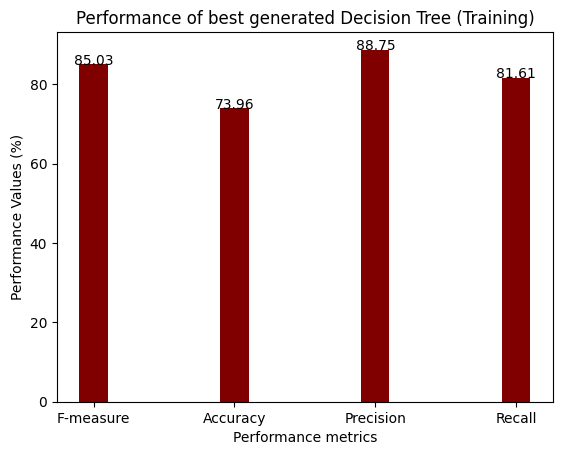

In [70]:
random.seed(827384)
# run source dataset - training
data_clean = source_data_clean
population_size = 50
max_depth=5
generations = 1
chromosome_min_limit = 8
chromosome_max_limit = 20 # number of codons that are allowed in one chromosome
tourney_size = 5
mutation_rate = 0.15
crossover_rate = 0.9
params = [generations, population_size, max_depth, chromosome_min_limit, chromosome_max_limit, tourney_size, mutation_rate, crossover_rate]
file_name = "source_seed_results_training.txt"

best_run = train_program(data_clean, params, file_name, source_data_results['without_learning'], source_individual=None)
source_individual_best = best_run[1]

In [55]:
# ['Pregnancies', '>=', 10.8742, [0], ['DiabetesPedigreeFunction', '>=', 1.0026, ['BloodPressure', '>=', 98.4778, [0], ['Insulin', '<=', 0.0, [0], [0]]], ['GLUCOSE', '>=', 153.0, [[0]], [0]]]]

In [56]:
# create expression rules
S_rule, F_rule, Op_rule, Child_rule = setupRules(X_train)
arr_tree, str_tree = mapChromosomeToTree(X_train, X_train, source_individual_best, S_rule, F_rule, Op_rule, Child_rule, max_depth)
print(arr_tree)

GLUCOSE
|======== inside not smoke
(GLUCOSE,<=,170.7811,<Child><Child>
GLUCOSE
|======== inside not smoke
(GLUCOSE,<,222.6953,<Child><Child>
(GLUCOSE,<,222.6953,(0)<Child>
(GLUCOSE,<=,170.7811,(GLUCOSE,<,222.6953,(0)(1)),<Child>
['GLUCOSE', '<=', 170.7811, ['GLUCOSE', '<', 222.6953, [0], [1]], [1]]



Generation: 1
Time to evaluate population: 2.302605152130127
Average Accuracy: 0.4107555555555556
Best Accuracy: 0.9185185185185185
F-measure: 0.9575289575289575
Precision: 1.0
Recall: 0.9185185185185185

Evolving population...

Elapsed: 4.3847267627716064

Generation: 2
Time to evaluate population: 2.4621760845184326
Average Accuracy: 0.8536888888888889
Best Accuracy: 0.9185185185185185
F-measure: 0.9575289575289575
Precision: 1.0
Recall: 0.9185185185185185

Evolving population...

Elapsed: 4.410763740539551

Generation: 3
Time to evaluate population: 2.2965657711029053
Average Accuracy: 0.9165925925925926
Best Accuracy: 0.9185185185185185
F-measure: 0.9575289575289575
Precision: 1.0
Recall: 0.9185185185185185

Evolving population...

Elapsed: 4.525668144226074

Generation: 4
Time to evaluate population: 2.3157613277435303
Average Accuracy: 0.8950814814814814
Best Accuracy: 0.9185185185185185
F-measure: 0.9575289575289575
Precision: 1.0
Recall: 0.9185185185185185

Evolving population

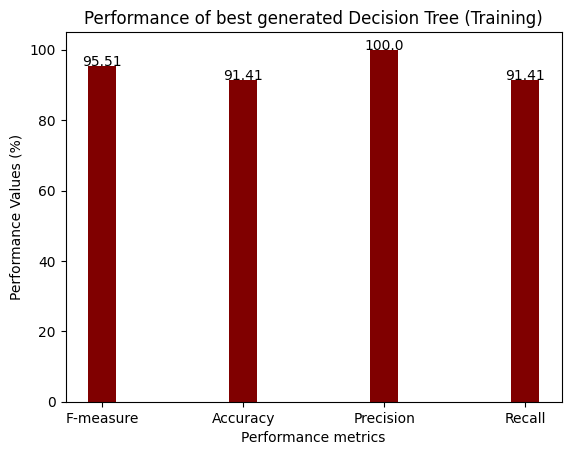

In [71]:
random.seed(2323)
# run source dataset - training
data_clean = target_one_data_clean[:900]
population_size = 50
max_depth=5
generations = 10
chromosome_min_limit = 8
chromosome_max_limit = 20 # number of codons that are allowed in one chromosome
tourney_size = 3
mutation_rate = 0.1
crossover_rate = 0.87
params = [generations, population_size, max_depth, chromosome_min_limit, chromosome_max_limit, tourney_size, mutation_rate, crossover_rate]
file_name = "target1_seed_results_training_learning.txt"

best_run = train_program(data_clean, params, file_name, target_one_data_results['with_learning'], source_individual=source_individual_best)

# test target one dataset - without learning
trained_individual = best_run[1]
file_name = "target1_seed_results_testing_learning.txt"
# test_program(target_one_data_results['with_learning'], data_clean, trained_individual, file_name)

# folder_path = 'results'
    
# for file in os.listdir('/kaggle/working/' + folder_path):
#     display(HTML('<a href=' + folder_path + '/' + file + '>' + file + '</a>'))


# ====================================================================================================
# ['11000010', '01110111', '10101001', '10100010', '00000001', '10001111', '10010011', '10000001', '10111111', '00010111', '10001000']
# ====================================================================================================

In [ ]:
# create expression rules
S_rule, F_rule, Op_rule, Child_rule = setupRules(X_train)
arr_tree, str_tree = mapChromosomeToTree(X_train, X_train, trained_individual, S_rule, F_rule, Op_rule, Child_rule, max_depth)
print(arr_tree)